In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize, basinhopping
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.stats.sandwich_covariance import cov_hc1
from sklearn.linear_model import LogisticRegression
import warnings
import pyreadstat

In [2]:

# Prepare data for SCM using MSCMT (R) via subprocess
# Python handles all data wrangling; R only runs MSCMT

from pathlib import Path
import subprocess
import pandas as pd

base_dir = Path('replication')
data_path = base_dir / 'CountryEPData.dta'
cov_path = base_dir / 'CountryEPData_covIP.dta'
input_path = base_dir / '_mscmt_input.csv'

# Prepare long data in Python
raw_dat = pd.read_stata(data_path)
raw_cov, _ = pyreadstat.read_dta(cov_path)
raw_dat = raw_dat.merge(raw_cov, on=['ccode', 'year', 'ep_election'], how='left')
raw_dat = raw_dat[~raw_dat['ccode'].isin([5, 9, 12])]  # drop Denmark, Sweden, Germany
raw_dat = raw_dat[raw_dat['ep_election'] != 2019]
raw_dat = raw_dat[raw_dat['year'].isin(raw_dat['ep_election'].unique())]
keep_cols = ['rr_votes','E_eubadIP','E_NatDem_satisfiedIP','unempIP','opencIP','S_uegenIP',
             'rightgovIP','ch_imp_fns','eu_pos_meanIP','ccode','country','ep_election']
raw_dat[keep_cols].to_csv(input_path, index=False)


def run_mscmt(drop_france=True, tag='base'):
    out_dir = base_dir / f'_scm_mscmt_{tag}'
    out_dir.mkdir(exist_ok=True, parents=True)
    drop_fr = 'TRUE' if drop_france else 'FALSE'
    r_script = f"""
    suppressPackageStartupMessages({{ library(MSCMT) }})
    dat <- read.csv('{input_path.as_posix()}')
    dat$ccode <- as.integer(dat$ccode)
    if ({drop_fr}) dat <- subset(dat, subset=dat$ccode != 6)
    dat <- as.data.frame(dat)
    dat <- listFromLong(dat, unit.variable='ccode', unit.names.variable='country', time.variable='ep_election')
    treatment_id <- 'United Kingdom'
    controls_id  <- setdiff(colnames(dat[[1]]), treatment_id)
    times_dep  <- cbind('rr_votes' = c(1979,1994))
    times_pred <- cbind(
                    'E_eubadIP' = c(1979,1994),
                    'E_NatDem_satisfiedIP' = c(1979,1994),
                    'unempIP' = c(1979,1994),
                    'opencIP' = c(1979,1994),
                    'S_uegenIP' = c(1979,1994),
                    'rightgovIP' = c(1979,1994),
                    'ch_imp_fns' = c(1979,1994),
                    'eu_pos_meanIP' = c(1979,1994),
                    'rr_votes' = c(1994)
    )
    seeds <- sample(4322:97834, 5, replace=FALSE)
    res <- mscmt(dat, treatment_id, controls_id, times_dep, times_pred,
                 agg.fns=rep('id', ncol(times_pred)),
                 inner.optim='wnnlsOpt',
                 outer.optim='DEoptC',
                 outer.par=list(lb=1e-9, opt.separate=TRUE),
                 seed=seeds, check.global=TRUE,
                 placebo=TRUE, placebo.with.treated=FALSE,
                 return.ts=FALSE)
    s <- res[[1]]
    main <- cbind(year=as.numeric(names(s$data.treat$rr_votes)),
                  Y1=as.numeric(s$data.treat$rr_votes),
                  Y0_synth=as.numeric(s$data.synth$rr_votes))
    write.csv(main, file='{(out_dir / 'main.csv').as_posix()}', row.names=FALSE)
    gaps <- cbind(year=as.numeric(names(s$gaps$rr_votes)), gap=as.numeric(s$gaps$rr_votes))
    write.csv(gaps, file='{(out_dir / 'gaps.csv').as_posix()}', row.names=FALSE)
    w <- cbind(control=names(s$w), weight=as.numeric(s$w))
    write.csv(w, file='{(out_dir / 'weights.csv').as_posix()}', row.names=FALSE)
    pgaps <- res$placebo$rr_votes$gaps
    pgaps_df <- cbind(year=as.numeric(rownames(pgaps)), as.data.frame(pgaps))
    write.csv(pgaps_df, file='{(out_dir / 'placebo_gaps.csv').as_posix()}', row.names=FALSE)
    """
    cmd = ['Rscript', '-e', r_script]
    result = subprocess.run(cmd, capture_output=True, text=True)
    if result.returncode != 0:
        raise RuntimeError(f"Rscript failed: {result.stderr}")
    main_df = pd.read_csv(out_dir/'main.csv')
    gaps_df = pd.read_csv(out_dir/'gaps.csv')
    weights_df = pd.read_csv(out_dir/'weights.csv')
    placebo_df = pd.read_csv(out_dir/'placebo_gaps.csv')
    return main_df, gaps_df, weights_df, placebo_df

main_base, gaps_base, weights_base, placebo_base = run_mscmt(drop_france=True, tag='base')
main_fr, gaps_fr, weights_fr, placebo_fr = run_mscmt(drop_france=False, tag='with_fr')

scm_base = {
    'years': main_base['year'].tolist(),
    'Y1': main_base['Y1'].to_numpy(),
    'Y_synth': main_base['Y0_synth'].to_numpy(),
    'gaps': gaps_base['gap'].to_numpy(),
    'weights': weights_base
}
scm_with_fr = {
    'years': main_fr['year'].tolist(),
    'Y1': main_fr['Y1'].to_numpy(),
    'Y_synth': main_fr['Y0_synth'].to_numpy(),
    'gaps': gaps_fr['gap'].to_numpy(),
    'weights': weights_fr
}
placebos_with_fr = placebo_fr

years_plot = sorted(set(main_base['year']))
plot_dat = pd.read_stata(base_dir / 'CountryEPData.dta')
plot_dat = plot_dat[(plot_dat['ep_election'] != 2019) & (plot_dat['year'].isin(plot_dat['ep_election'].unique()))]
eu8_avg = plot_dat[plot_dat['ccode'] != 11].groupby('ep_election')['rr_votes'].mean().reindex(years_plot).values
westminster = pd.read_csv('replication/westminster.csv')
westminster = westminster[westminster['year'] <= 2014]


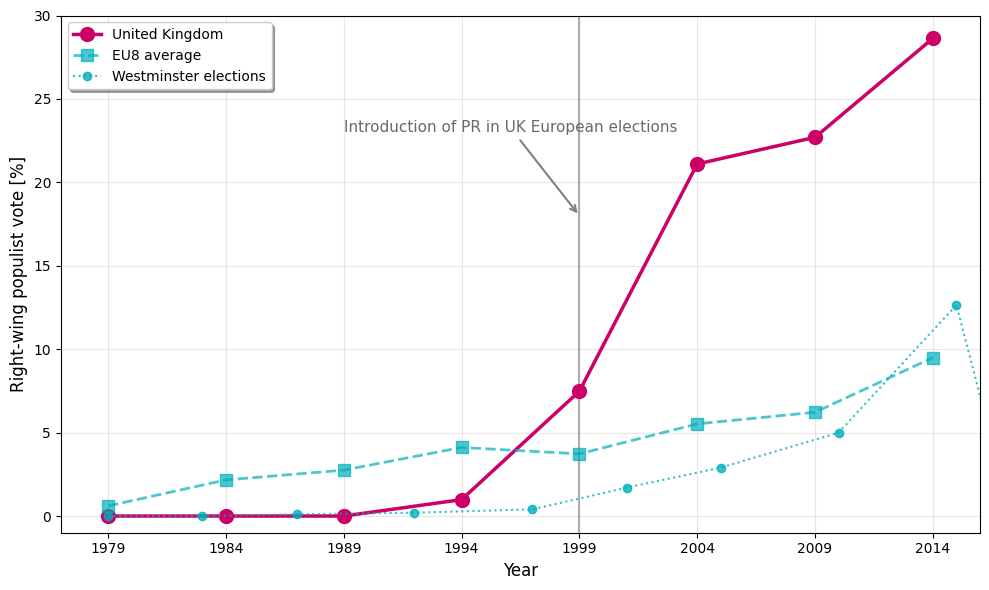

Figure 1: UK vs EU8 Average RWP Votes


In [3]:

# Prepare data for plotting
# Use full dataset (exclude only UK) for EU8 average to match R plot
plot_dat = pd.read_stata('replication/CountryEPData.dta')
plot_dat = plot_dat[plot_dat['ep_election'] != 2019]
plot_dat = plot_dat[plot_dat['year'].isin(plot_dat['ep_election'].unique())]

years_plot = sorted(plot_dat['ep_election'].unique())
uk_votes = plot_dat[plot_dat['ccode'] == 11].set_index('ep_election')['rr_votes'].reindex(years_plot).values
eu8_avg = plot_dat[plot_dat['ccode'] != 11].groupby('ep_election')['rr_votes'].mean().reindex(years_plot).values

westminster = pd.read_csv('replication/westminster.csv')
#westminster = westminster[westminster['year'].isin(years_plot)]

fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
ax.set_axisbelow(True)
ax.axvline(1999, color='gray', linewidth=1.5, linestyle='-', alpha=0.6)

ax.plot(years_plot, uk_votes, 'o-', color='#CC0066', linewidth=2.5,
        markersize=10, label='United Kingdom', markerfacecolor='#CC0066')
ax.plot(years_plot, eu8_avg, 's--', color='#00AFBB', linewidth=2,
        markersize=8, label='EU8 average', alpha=0.7)
ax.plot(westminster['year'], westminster['westminster_vote'],
        'o:', color='#00AFBB', linewidth=1.5, markersize=6,
        label='Westminster elections', alpha=0.8)

ax.annotate('Introduction of PR in UK European elections',
           xy=(1999, 18), xytext=(1989, 23),
           arrowprops=dict(arrowstyle='->', color='gray', lw=1.5),
           fontsize=11, color='dimgray')

ax.set_xlim(1977, 2016)
ax.set_ylim(-1, 30)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Right-wing populist vote [%]', fontsize=12)
ax.legend(loc='upper left', fontsize=10, frameon=True, fancybox=True, shadow=True)
ax.set_xticks(years_plot)

plt.tight_layout()
plt.show()

print("Figure 1: UK vs EU8 Average RWP Votes")


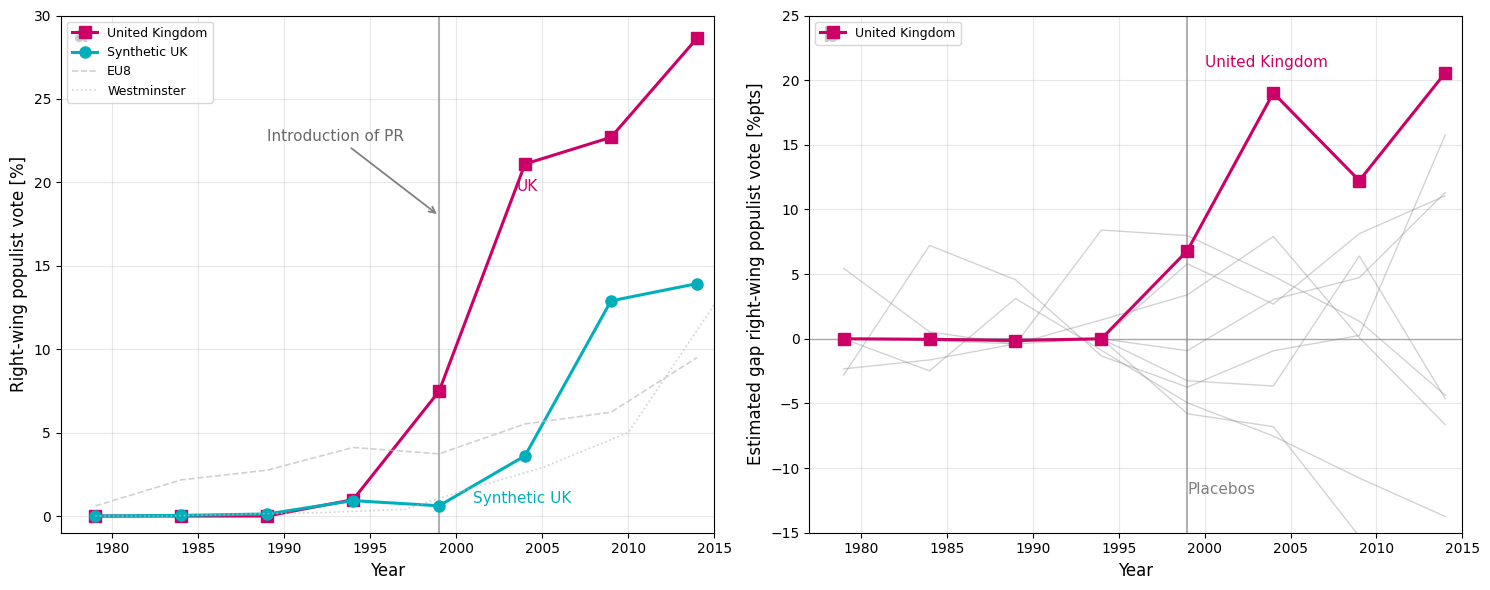

In [4]:
# Create two-panel figure comparing exclusion/inclusion of France
controls_base = sorted(raw_dat.loc[~raw_dat['ccode'].isin([5,6,9,12,11]), 'ccode'].unique())
controls_with_fr = sorted(raw_dat.loc[~raw_dat['ccode'].isin([5,9,12,11]), 'ccode'].unique())


# Create two-panel figure comparing exclusion/inclusion of France
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Panel a: baseline exclusion (match MSCMT)
ax1 = axes[0]
ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
ax1.set_axisbelow(True)
ax1.axvline(1999, color='gray', linewidth=1.5, linestyle='-', alpha=0.6)

ax1.plot(scm_base['years'], scm_base['Y1'], 's-', color='#CC0066', linewidth=2.2,
         markersize=8, label='United Kingdom', markerfacecolor='#CC0066')
ax1.plot(scm_base['years'], scm_base['Y_synth'], 'o-', color='#00AFBB', linewidth=2.2,
         markersize=8, label='Synthetic UK', markerfacecolor='#00AFBB')
ax1.plot(years_plot, eu8_avg, '--', color='#BEBEBE', linewidth=1.2, alpha=0.7, label='EU8')
ax1.plot(westminster['year'], westminster['westminster_vote'], ':', color='#BEBEBE', linewidth=1.2,
         label='Westminster', alpha=0.7)

ax1.annotate('Introduction of PR', xy=(1999, 18), xytext=(1989, 22.5),
            arrowprops=dict(arrowstyle='->', color='gray', lw=1.3),
            fontsize=11, color='dimgray')
ax1.set_xlim(1977, 2015)
ax1.set_ylim(-1, 30)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Right-wing populist vote [%]', fontsize=12)
ax1.legend(loc='upper left', fontsize=9)
ax1.text(0.02, 0.98, 'a', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top')
ax1.text(2003.5, 19.5, 'UK', color='#CC0066', fontsize=11)
ax1.text(2001, 0.8, 'Synthetic UK', color='#00AFBB', fontsize=11)

# Panel b: include France and show placebo gaps
ax2 = axes[1]
ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
ax2.set_axisbelow(True)
ax2.axvline(1999, color='gray', linewidth=1.5, linestyle='-', alpha=0.6)
ax2.axhline(0, color='gray', linewidth=1.0, linestyle='-', alpha=0.6)

# Placebo gaps
for ccode, gaps in placebos_with_fr.items():
    ax2.plot(scm_with_fr['years'], gaps, '-', color='gray', linewidth=1.0, alpha=0.35)

# UK gap
ax2.plot(scm_with_fr['years'], scm_with_fr['gaps'], 's-', color='#CC0066',
         linewidth=2.2, markersize=8, label='United Kingdom')

ax2.set_xlim(1977, 2015)
ax2.set_ylim(-15, 25)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Estimated gap right-wing populist vote [%pts]', fontsize=12)
ax2.legend(loc='upper left', fontsize=9)
ax2.text(0.02, 0.98, 'b', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top')
ax2.text(2000, 21, 'United Kingdom', color='#CC0066', fontsize=11)
ax2.text(1999, -12, 'Placebos', color='gray', fontsize=11)

plt.tight_layout()
plt.show()


